In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
from typing import List, Tuple
import uproot3

In [2]:
save_plots = False

with_dtf = True
with_pidsubs = False
with_protoparticles = False
with_2Ddebug = True

In [3]:
color_3D = 'tab:blue'
color_2D = 'tab:orange'

In [4]:
ls ~/data/2D_recovery_studies/increased_covmatrix

all_2D/        s_0.4/  s_0.82/  s_0.92/  xyz_blowup/
higher_stats/  s_0.5/  s_0.84/  s_0.94/  xyz_seq_highstats_id/
s_0.1/         s_0.6/  s_0.86/  s_0.96/  xyz_seq_withId/
s_0.2/         s_0.7/  s_0.88/  s_0.98/  y_blowup/
s_0.3/         s_0.8/  s_0.9/   s_1/     z_blowup/


In [5]:
input_file = (
    str(pathlib.Path.home())
    + '/data/2D_recovery_studies/increased_covmatrix/xyz_seq_highstats_id/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_with2D.root'
)

In [6]:
## Create plots directory, if missing
plots_dir = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/'
                  + 'plots/'
                  + 'studies_on_integrated_root_files/'
                  + 'xyz_sequential_blowup_performance_study/'
)
pathlib.Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Import data

In [7]:
def root_file_to_df(
    filename: str,
    branchlist: List[str]
) -> pd.DataFrame:
    with uproot3.open(filename) as file_root:
        tree = file_root['Lb_T/DecayTree']
        ## Load dataFrame with desired branches
        #df = tree.pandas.df(branchlist, flatten=False)
        df = tree.pandas.df(branchlist).loc[(slice(None), 0), :]
        ## Reset indices
        df.reset_index(drop=True, inplace=True)
        return df

In [8]:
composite_particles = ['Lb', 'L', 'Jpsi']
basic_particles = ['p', 'pim', 'mum', 'mup']
lambda_baryons = ['L', 'Lb']

lambdab_daughters = ['L', 'Jpsi']
lambdab_daughters_DTF = ['Lambda0', 'J_psi_1S']

lambdab_nephews = {
    'L': ['p', 'pim'],
    'Jpsi': ['mum', 'mup'],
}
lambdab_nephews_DTF = {
    'Lambda0': ['pplus', 'piplus'],
    'J_psi_1S': ['muminus_0', 'muminus'],
}

DTF_mass_constraints = ['FixJPsi', 'FixJPsiLambda']

## Original names (v1.1)

In [9]:
## Reco branches
reco_branches = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_ENDVERTEX_' + component)
    reco_branches.append(prefix + '_M')
    reco_branches.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_P' + component)
    reco_branches.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches.append(prefix + '_BPVDIRA')
    reco_branches.append(prefix + '_BPVIPCHI2')
    reco_branches.append(prefix + '_BPVVDCHI2')
    reco_branches.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches.append('Lb_OWNPV_' + feature)

reco_branches.append('Polarity')

## Truth branches
truth_branches = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEP_' + component)

truth_branches.append('L_MC_MOTHER_ID')
truth_branches.append('Lb_MC_MOTHER_ID')
        
for prefix in basic_particles + composite_particles:
    truth_branches.append(prefix + '_Reconstructible')
    truth_branches.append(prefix + '_Reconstructed')

## DTF branches
dtf_branches = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_status')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_M')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_P')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_chi2')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_M')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_P')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_' + daughter + '_P' + component)
                    
    pidsubs_branches.append('TrackType')

## Protoparticle branches
pp_branches = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches = []
if with_2Ddebug:
    debug_branches.append('L_ENDVERTEX_XERR')
    debug_branches.append('L_ENDVERTEX_YERR')
    debug_branches.append('L_ENDVERTEX_ZERR')
    debug_branches.append('L_ALGO_ID')
    
branches = reco_branches + truth_branches + dtf_branches + pp_branches + pidsubs_branches + debug_branches

## New names (v1.1)

In [10]:
## Reco branches
reco_branches_renamed = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_ENDVERTEX_' + component)
    reco_branches_renamed.append(prefix + '_M')
    reco_branches_renamed.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_P' + component)
    reco_branches_renamed.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches_renamed.append(prefix + '_BPVDIRA')
    reco_branches_renamed.append(prefix + '_BPVIPCHI2')
    reco_branches_renamed.append(prefix + '_BPVVDCHI2')
    reco_branches_renamed.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches_renamed.append('Lb_OWNPV_' + feature)

reco_branches_renamed.append('Polarity')

## Truth branches
truth_branches_renamed = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_ENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_P' + component)

truth_branches_renamed.append('MCTRUTH_L_ID')
truth_branches_renamed.append('MCTRUTH_Lb_ID')
        
for prefix in basic_particles + composite_particles:
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructible')
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructed')

## DTF branches
dtf_branches_renamed = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_status')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_M')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_P')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_chi2')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches_renamed.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters:
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches_renamed = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_M')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_P')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + daughter + '_P' + component)
                    
    pidsubs_branches_renamed.append('TrackType')

## Protoparticle branches
pp_branches_renamed = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches_renamed.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches_renamed.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches_renamed = []
if with_2Ddebug:
    debug_branches_renamed.append('L_ENDVERTEX_XERR')
    debug_branches_renamed.append('L_ENDVERTEX_YERR')
    debug_branches_renamed.append('L_ENDVERTEX_ZERR')
    debug_branches_renamed.append('L_ALGO_ID')
    
branches_renamed = reco_branches_renamed + truth_branches_renamed + dtf_branches_renamed + pp_branches_renamed + pidsubs_branches_renamed + debug_branches_renamed

In [11]:
if len(branches_renamed) != len(branches):
    raise ValueError("Number of columns before and after renaming does not match.")

In [12]:
df_events = root_file_to_df(input_file, branches)

column_rename_dictionary = {}
for old_name, new_name in zip(branches, branches_renamed):
    column_rename_dictionary[old_name] = new_name

df_events.rename(columns=column_rename_dictionary, inplace=True)

In [13]:
algo_id_dictionary = {
    -10: 'NonConverged',
     -1: 'Unspecified',
      0: 'VertexFitter',
      1: 'XBlownUpAlgorithm',
      2: 'YBlownUpAlgorithm',
      3: 'XYBlownUpAlgorithm',
      4: 'ZBlownUpAlgorithm',
      5: 'XZBlownUpAlgorithm',
      6: 'YZBlownUpAlgorithm',
      7: 'XYZBlownUpAlgorithm',
     10: 'Generic2DAlgorithm',
}

In [14]:
df_events.replace({'L_ALGO_ID': algo_id_dictionary}, inplace=True)

In [15]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,DTF_FixJPsiLambda_mum_PX,DTF_FixJPsiLambda_mum_PY,DTF_FixJPsiLambda_mum_PZ,DTF_FixJPsiLambda_mup_PX,DTF_FixJPsiLambda_mup_PY,DTF_FixJPsiLambda_mup_PZ,L_ENDVERTEX_XERR,L_ENDVERTEX_YERR,L_ENDVERTEX_ZERR,L_ALGO_ID
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,2336.726807,1955.337524,51449.074219,6890.645996,2277.178955,71799.851562,6.071491,0.980073,88.062710,VertexFitter
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,5243.780273,3825.376953,62066.906250,1062.750366,2703.485840,43083.328125,14.068567,8.805921,117.764454,VertexFitter
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,-1195.397583,-1052.931274,24634.527344,926.159241,707.330261,6450.025391,1.887029,3.525798,147.576765,VertexFitter
3,0.605714,-0.203049,22.148035,5645.205401,5601.574674,-202.498747,18.725639,3762.349599,1179.755864,1134.066434,...,-161.622650,906.991150,7621.356934,-3748.910889,-1716.463745,31680.648438,14.593576,2.032065,268.079984,XBlownUpAlgorithm
4,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,-3774.639160,621.073181,31214.998047,584.359314,162.299011,8451.527344,0.947925,0.759450,31.816149,VertexFitter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,0.792793,-0.153357,-27.134301,5552.073384,5700.196864,-63.514990,5.060145,467.127720,1075.296644,1102.470790,...,696.836182,99.462181,7429.670898,-3169.695068,-1007.203369,46898.406250,62.621629,33.249437,691.170906,VertexFitter
2393,0.715787,-0.237929,-24.543360,5580.116199,5538.928843,-260.224385,121.363209,5265.321387,1082.767384,1090.171388,...,825.803528,129.734085,11280.424805,-2339.193359,-1672.800049,25418.917969,14.382491,6.421728,272.762825,XBlownUpAlgorithm
2394,1.025268,-0.347555,110.111895,5563.561252,5484.832574,14.961722,-29.933930,2339.392177,1153.081028,1154.792714,...,1895.756836,1054.694092,40788.437500,61.894775,-1411.220337,16714.876953,8.677290,11.566475,737.487677,VertexFitter
2395,0.555001,-0.282748,58.317676,-120555.108929,25778.611947,-297.812857,-92.954604,6092.902518,-3231.821376,1528.140408,...,-1810.111206,-672.167542,31450.732422,-5517.131348,-3464.008789,241217.609375,25.601101,7.419865,567.158147,YBlownUpAlgorithm


# Helper functions

In [16]:
def plot_single_histogram(
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True,
    median_line: bool = False
):
    
    plt.hist(
        series,
        bins=binning,
        range=boundaries,
        histtype='stepfilled',
        edgecolor=color_3D,
        color=mcolors.to_rgba(color_3D, alpha=0.05),
        density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
        
    if median_line:
        plt.axvline(x=series.median(), ymin=0, ymax=1, label='Median', color='black', linestyle='--')
        plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [17]:
def plot_2D_vs_3D_histograms(
    df: pd.DataFrame, ## Full DataFrame
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True
):
    is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
    
    ## 3D-converged events
    plt.hist(
        series.loc[is_VF],
        bins=binning,
        range=boundaries,
        label="Vertex Fitter",
        histtype='stepfilled',
        edgecolor=color_3D,
        color=mcolors.to_rgba(color_3D, alpha=0.05),
        density=normalized
    )
    
    ## Failed
    plt.hist(
        series.loc[~is_VF],
         bins=binning,
         range=boundaries,
         label="2D algorithms",
         histtype='stepfilled',
         edgecolor=color_2D,
         color=mcolors.to_rgba(color_2D, alpha=0.05),
         density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
    
    plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [18]:
def plot_single_hist2D(
    series_x: pd.Series,
    series_y: pd.Series,
    label_x: str,
    label_y: str,
    range_x: List[float],
    range_y: List[float],
    title: str,
    binning: int,
    file_name: str,
    show_title: bool = True,
    black_and_white: bool = False
) -> None:
    
    plot_params = {
        'range': [range_x, range_y],
        'bins': binning
    }
    
    if black_and_white:
        plot_params['cmap'] = 'gray'
    else:
        plot_params['cmap'] = 'turbo'
        
    plt.hist2d(series_x, series_y, **plot_params)
    
    if show_title:
        plt.title(title)
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.colorbar(label='Events')
    
    plt.show()

# Increase in statistics and other raw numbers

In [19]:
is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
is_2D = df_events['L_ALGO_ID'].isin(['XBlownUpAlgorithm', 'YBlownUpAlgorithm', 'ZBlownUpAlgorithm'])
is_unexpected = (~is_VF & ~is_2D)

is_X = df_events['L_ALGO_ID'] == 'XBlownUpAlgorithm'
is_Y = df_events['L_ALGO_ID'] == 'YBlownUpAlgorithm'
is_Z = df_events['L_ALGO_ID'] == 'ZBlownUpAlgorithm'

In [20]:
tot_events = len(df_events)
recovered_events = sum(is_2D)
unexpected_events = sum(is_unexpected)

In [21]:
print("Tot. number of events:\t\t\t\t", tot_events)
print("Tot. number of recovered events:\t\t", recovered_events)
print("Tot. number of unrecognized events:\t\t", unexpected_events)

Tot. number of events:				 2397
Tot. number of recovered events:		 484
Tot. number of unrecognized events:		 0


In [22]:
print("Statistics increase:\t\t\t\t", "{:.1%}".format(recovered_events/(tot_events-recovered_events)))

Statistics increase:				 25.3%


Of the new events:

In [23]:
print("Reconstructed with 2D algo, x-blowup:\t\t", "{:.2%}".format(sum(is_X)/recovered_events))
print("Reconstructed with 2D algo, y-blowup:\t\t", "{:.2%}".format(sum(is_Y)/recovered_events))
print("Reconstructed with 2D algo, z-blowup:\t\t", "{:.2%}".format(sum(is_Z)/recovered_events))

Reconstructed with 2D algo, x-blowup:		 58.68%
Reconstructed with 2D algo, y-blowup:		 36.57%
Reconstructed with 2D algo, z-blowup:		 4.75%


In [24]:
condition = is_VF
algo = 'VF'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t", "{:.2%}".format(series.std()))

VF mean chi2:				 1466.94
VF median chi2:				 0.97
VF chi2 std:				 46934.01

VF mean L0 vertex z bias:		 484.47
VF median L0 vertex z bias:		 438.19
VF L0 vertex z bias std:		 2659.36

VF mean proton p_z relative bias:	 27227.93%
VF median proton p_z relative bias:	 1.29%
VF proton p_z bias relative std:	 1147728.62%


In [25]:
condition = is_X | is_Y | is_Z
algo = '2D algos'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t\t", "{:.2%}".format(series.std()))

2D algos mean chi2:				 956.02
2D algos median chi2:				 6.48
2D algos chi2 std:				 13804.96

2D algos mean L0 vertex z bias:			 968.39
2D algos median L0 vertex z bias:		 645.95
2D algos L0 vertex z bias std:			 1099.89

2D algos mean proton p_z relative bias:		 32666.75%
2D algos median proton p_z relative bias:	 -0.93%
2D algos proton p_z bias relative std:		 699410.27%


In [26]:
condition = is_X
algo = '2DX algo'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t\t", "{:.2%}".format(series.std()))

2DX algo mean chi2:				 1584.47
2DX algo median chi2:				 6.05
2DX algo chi2 std:				 18007.74

2DX algo mean L0 vertex z bias:			 886.94
2DX algo median L0 vertex z bias:		 574.41
2DX algo L0 vertex z bias std:			 1067.98

2DX algo mean proton p_z relative bias:		 -10277.54%
2DX algo median proton p_z relative bias:	 -0.46%
2DX algo proton p_z bias relative std:		 298924.78%


In [27]:
condition = is_Y
algo = '2DY algo'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t\t", "{:.2%}".format(series.std()))

2DY algo mean chi2:				 50.88
2DY algo median chi2:				 6.67
2DY algo chi2 std:				 137.40

2DY algo mean L0 vertex z bias:			 1006.31
2DY algo median L0 vertex z bias:		 804.34
2DY algo L0 vertex z bias std:			 960.93

2DY algo mean proton p_z relative bias:		 76675.13%
2DY algo median proton p_z relative bias:	 -2.20%
2DY algo proton p_z bias relative std:		 1022124.80%


In [28]:
condition = is_Z
algo = '2DZ algo'

series = df_events.loc[condition, 'L_VFASPF_CHI2_VDOF']

print(algo + " mean chi2:\t\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median chi2:\t\t\t\t", '{:.2f}'.format(series.median()))
print(algo + " chi2 std:\t\t\t\t", '{:.2f}'.format(series.std()))

print()

series = (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z']).loc[condition]

print(algo + " mean L0 vertex z bias:\t\t\t", '{:.2f}'.format(series.mean()))
print(algo + " median L0 vertex z bias:\t\t", '{:.2f}'.format(series.median()))
print(algo + " L0 vertex z bias std:\t\t\t", '{:.2f}'.format(series.std()))

print()

series = ((df_events['DTF_FixJPsi_p_PZ'] - df_events['MCTRUTH_p_PZ'])/df_events['MCTRUTH_p_PZ']).loc[condition]

print(algo + " mean proton p_z relative bias:\t\t", "{:.2%}".format(series.mean()))
print(algo + " median proton p_z relative bias:\t", "{:.2%}".format(series.median()))
print(algo + " proton p_z bias relative std:\t\t", "{:.2%}".format(series.std()))

2DZ algo mean chi2:				 161.65
2DZ algo median chi2:				 21.65
2DZ algo chi2 std:				 353.52

2DZ algo mean L0 vertex z bias:			 1682.22
2DZ algo median L0 vertex z bias:		 859.11
2DZ algo L0 vertex z bias std:			 1967.41

2DZ algo mean proton p_z relative bias:		 224262.25%
2DZ algo median proton p_z relative bias:	 0.76%
2DZ algo proton p_z bias relative std:		 1074470.19%


# $\Lambda^0$ decay vertex bias

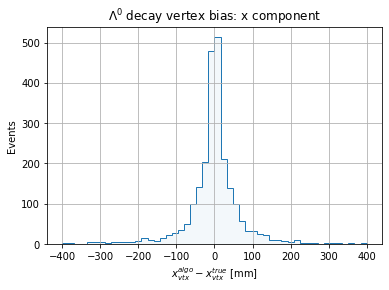

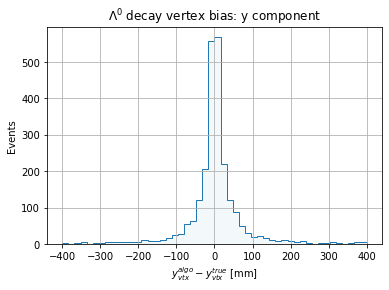

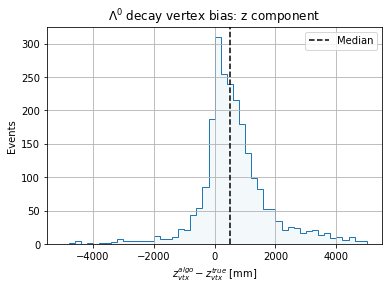

In [29]:
bias_boundary_dictionary = {
    'x': (-400,400),
    'y': (-400,400),
    'z': (-5000,5000),
}

for comp in ['x', 'y', 'z']:
    fitted_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{algo}_{vtx} - ' + comp + '^{true}_{vtx}$ [mm]',
        'plot_title': '$\Lambda^0$ decay vertex bias: ' + comp + " component",
        'file_name': 'Lambda_endvertex_' + comp + '_bias',
        'binning': 50,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }
    
    if comp == 'z':
        plot_args['median_line'] = True

    plot_single_histogram(
        df_events[fitted_feature] - df_events[true_feature],
        **plot_args)

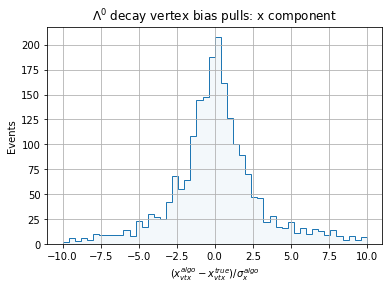

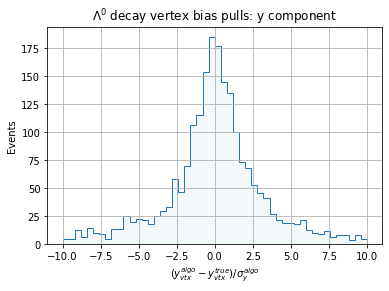

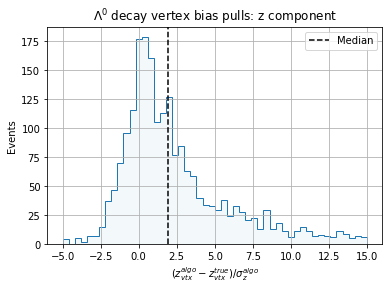

In [30]:
bias_boundary_dictionary = {
    'x': (-10,10),
    'y': (-10,10),
    'z': (-5,15),
}

for comp in ['x', 'y', 'z']:
    fitted_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    error_feature = 'L_ENDVERTEX_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{algo}_{vtx} - ' + comp + '^{true}_{vtx})/\sigma^{algo}_{' + comp + '}$',
        'plot_title': '$\Lambda^0$ decay vertex bias pulls: ' + comp + " component",
        'file_name': 'Lambda_endvertex_' + comp + '_bias_pulls',
        'binning': 50,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }
    
    if comp == 'z':
        plot_args['median_line'] = True

    plot_single_histogram(
        (df_events[fitted_feature] - df_events[true_feature])/df_events[error_feature],
        **plot_args)

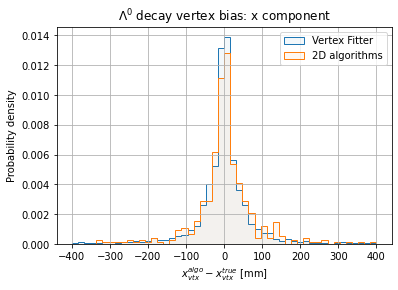

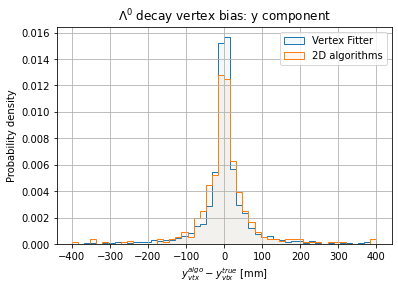

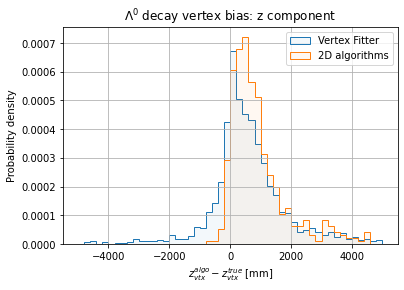

In [31]:
bias_boundary_dictionary = {
    'x': (-400,400),
    'y': (-400,400),
    'z': (-5000,5000),
}

for comp in ['x', 'y', 'z']:
    fitted_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{algo}_{vtx} - ' + comp + '^{true}_{vtx}$ [mm]',
        'plot_title': '$\Lambda^0$ decay vertex bias: ' + comp + " component",
        'file_name': 'Lambda_endvertex_' + comp + '_bias_2D_vs_3D',
        'binning': 50,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[fitted_feature] - df_events[true_feature],
        **plot_args)

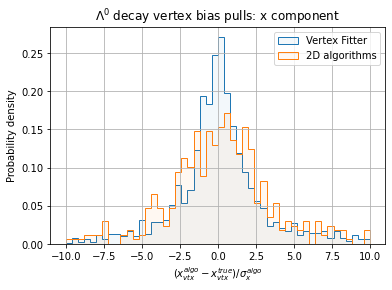

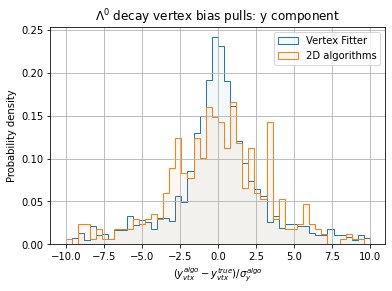

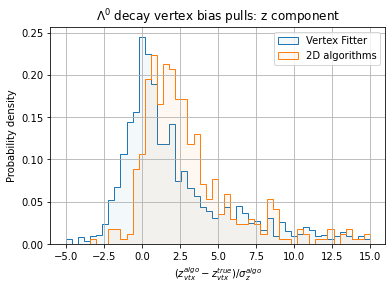

In [32]:
bias_boundary_dictionary = {
    'x': (-10,10),
    'y': (-10,10),
    'z': (-5,15),
}

for comp in ['x', 'y', 'z']:
    fitted_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    error_feature = 'L_ENDVERTEX_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{algo}_{vtx} - ' + comp + '^{true}_{vtx})/\sigma^{algo}_{' + comp + '}$',
        'plot_title': '$\Lambda^0$ decay vertex bias pulls: ' + comp + " component",
        'file_name': 'Lambda_endvertex_' + comp + '_bias_pulls_2D_vs_3D',
        'binning': 50,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[fitted_feature] - df_events[true_feature])/df_events[error_feature],
        **plot_args)

# Horizontality
"Horizontality" is a measure of how "horizontal" the decay plane is, i.e. its angle with the xz curving plane. Useful to check if events have been reconstructed "upside down".

In [33]:
def row_a_vec(row, p_pvec_column, pim_pvec_column):
    return np.cross(row[p_pvec_column], row[pim_pvec_column])

In [34]:
def row_a_norm(row, avec_column):
    return np.linalg.norm(row[avec_column])

In [35]:
def feature_component(series, component):
    return series.map(lambda x: x[component])

In [36]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,DTF_FixJPsiLambda_mum_PX,DTF_FixJPsiLambda_mum_PY,DTF_FixJPsiLambda_mum_PZ,DTF_FixJPsiLambda_mup_PX,DTF_FixJPsiLambda_mup_PY,DTF_FixJPsiLambda_mup_PZ,L_ENDVERTEX_XERR,L_ENDVERTEX_YERR,L_ENDVERTEX_ZERR,L_ALGO_ID
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,2336.726807,1955.337524,51449.074219,6890.645996,2277.178955,71799.851562,6.071491,0.980073,88.062710,VertexFitter
1,0.880395,-0.130333,15.654301,4900.959051,5196.066164,209.545799,199.243538,4381.083975,1228.240710,1286.308889,...,5243.780273,3825.376953,62066.906250,1062.750366,2703.485840,43083.328125,14.068567,8.805921,117.764454,VertexFitter
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,-1195.397583,-1052.931274,24634.527344,926.159241,707.330261,6450.025391,1.887029,3.525798,147.576765,VertexFitter
3,0.605714,-0.203049,22.148035,5645.205401,5601.574674,-202.498747,18.725639,3762.349599,1179.755864,1134.066434,...,-161.622650,906.991150,7621.356934,-3748.910889,-1716.463745,31680.648438,14.593576,2.032065,268.079984,XBlownUpAlgorithm
4,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,-3774.639160,621.073181,31214.998047,584.359314,162.299011,8451.527344,0.947925,0.759450,31.816149,VertexFitter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,0.792793,-0.153357,-27.134301,5552.073384,5700.196864,-63.514990,5.060145,467.127720,1075.296644,1102.470790,...,696.836182,99.462181,7429.670898,-3169.695068,-1007.203369,46898.406250,62.621629,33.249437,691.170906,VertexFitter
2393,0.715787,-0.237929,-24.543360,5580.116199,5538.928843,-260.224385,121.363209,5265.321387,1082.767384,1090.171388,...,825.803528,129.734085,11280.424805,-2339.193359,-1672.800049,25418.917969,14.382491,6.421728,272.762825,XBlownUpAlgorithm
2394,1.025268,-0.347555,110.111895,5563.561252,5484.832574,14.961722,-29.933930,2339.392177,1153.081028,1154.792714,...,1895.756836,1054.694092,40788.437500,61.894775,-1411.220337,16714.876953,8.677290,11.566475,737.487677,VertexFitter
2395,0.555001,-0.282748,58.317676,-120555.108929,25778.611947,-297.812857,-92.954604,6092.902518,-3231.821376,1528.140408,...,-1810.111206,-672.167542,31450.732422,-5517.131348,-3464.008789,241217.609375,25.601101,7.419865,567.158147,YBlownUpAlgorithm


In [37]:
## This computes (once) a new column in df named 'momenta_prefix_h',
## containing the related horizontality. Returns the related column.
def compute_horizontality(
    df: pd.DataFrame,
    momenta_prefix: str,
    p_px_column: str,
    p_py_column: str,
    p_pz_column: str,
    pim_px_column: str,
    pim_py_column: str,
    pim_pz_column :str,
):
      
    p_pvec_column = momenta_prefix + "_p_p_vec"
    pim_pvec_column = momenta_prefix + "_pim_p_vec"
    avec_column = momenta_prefix + "_a_vec"
    anorm_column = momenta_prefix + "_a_norm"
    ahat_column = momenta_prefix + "_a_hat"
    h_column = momenta_prefix + "_h"
    
    df[p_pvec_column] = list(zip(df[p_px_column], df[p_py_column], df[p_pz_column]))
    df[pim_pvec_column] = list(zip(df[pim_px_column], df[pim_py_column], df[pim_pz_column]))
    df[avec_column] = df.apply(lambda row: row_a_vec(row, p_pvec_column, pim_pvec_column), axis=1)
    df[anorm_column] = df.apply(lambda row: row_a_norm(row, avec_column), axis=1)
    df[ahat_column] = df[avec_column]/df[anorm_column]
    df[h_column] = feature_component(df[ahat_column], 1) * df['Polarity'] * np.sign(df['L_ID'])
    
    df.drop(columns=[
        p_pvec_column,
        pim_pvec_column,
        avec_column,
        anorm_column,
        ahat_column
    ], inplace=True)
    
    return h_column

In [38]:
h_reco_DTF = compute_horizontality(
    df=df_events, momenta_prefix="DTF_FixJPsi",
    p_px_column='DTF_FixJPsi_p_PX', p_py_column='DTF_FixJPsi_p_PY', p_pz_column='DTF_FixJPsi_p_PZ',
    pim_px_column='DTF_FixJPsi_pim_PX', pim_py_column='DTF_FixJPsi_pim_PY', pim_pz_column='DTF_FixJPsi_pim_PZ'
)

In [39]:
h_truth = compute_horizontality(
    df=df_events, momenta_prefix="MCTRUTH",
    p_px_column='MCTRUTH_p_PX', p_py_column='MCTRUTH_p_PY', p_pz_column='MCTRUTH_p_PZ',
    pim_px_column='MCTRUTH_pim_PX', pim_py_column='MCTRUTH_pim_PY', pim_pz_column='MCTRUTH_pim_PZ'
)

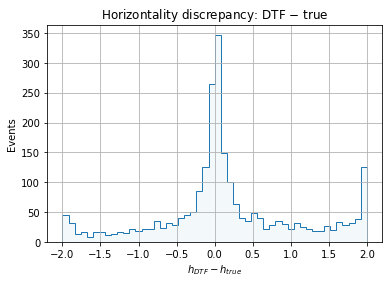

In [40]:
plot_args = {
    'axis_label': '$h_{DTF} - h_{true}$',
    'plot_title': 'Horizontality discrepancy: DTF $-$ true',
    'file_name': 'h_DTF_minus_true',
    'binning': 50,
    'boundaries': (-2,2),
    'log_scale': False,
    'scientific_notation': False,
    'normalized': False
}

plot_single_histogram(
    df_events['DTF_FixJPsi_h'] - df_events['MCTRUTH_h'],
    **plot_args)

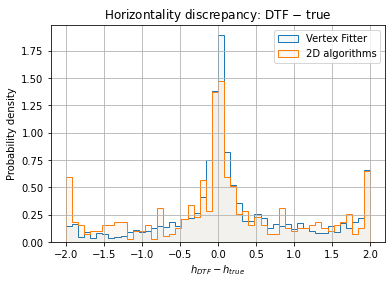

In [41]:
plot_args = {
    'axis_label': '$h_{DTF} - h_{true}$',
    'plot_title': 'Horizontality discrepancy: DTF $-$ true',
    'file_name': 'h_DTF_minus_true_2D_vs_3D',
    'binning': 50,
    'boundaries': (-2,2),
    'log_scale': False,
    'scientific_notation': False,
    'normalized': True
}

plot_2D_vs_3D_histograms(
    df_events,
    df_events['DTF_FixJPsi_h'] - df_events['MCTRUTH_h'],
    **plot_args)

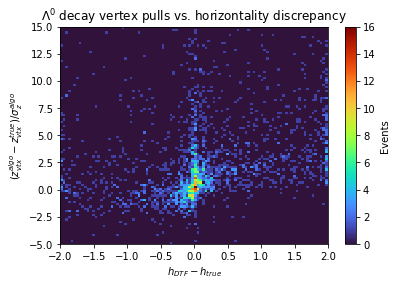

In [42]:
plot_parameters = {
    'binning': 100,
    'title': '$\Lambda^0$ decay vertex pulls vs. horizontality discrepancy',
    'label_x': '$h_{DTF} - h_{true}$',
    'label_y': '$(z^{algo}_{vtx} - z^{true}_{vtx})/\sigma^{algo}_{z}$',
    'show_title': True,
    'black_and_white': False,
    'range_x': [-2,2],
    'range_y': [-5,15],
    'file_name': 'h_DTF_minus_true_vs_Lambda_endvertex_z_bias_pulls',
}

plot_single_hist2D(
    df_events['DTF_FixJPsi_h'] - df_events['MCTRUTH_h'],
    (df_events['L_ENDVERTEX_Z'] - df_events['MCTRUTH_L_ENDVERTEX_Z'])/df_events['L_ENDVERTEX_ZERR'],
    **plot_parameters
)